In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas as pd

In [2]:
cwidth = 4
cheight = cwidth / 1.618 #Divine proportion!

label_size = 0
tick_size = 0
text_size = 0

def set_text_size(c):
    label_size = 10 * c / 2.2#2.73 #Multiply by 4/2.73 since figures are going to have 2.73 inches in final pdf 
    #label_size = 12 * c / 2.73 #Multiply by 4/2.73 since figures are going to have 2.73 inches in final pdf 
    tick_size = 8 * c / 2.2#2.73
    text_size = 12 * c / 2.2#2.73
    tick_size = 12 * c / 2.2#2.73
    
    params = {"axes.labelsize": label_size, "font.family":"sans-serif", "font.serif":"Helvetica",
         "xtick.labelsize": tick_size, "ytick.labelsize":tick_size}
    sns.set_context("paper", rc=params)
    return label_size, tick_size, text_size

label_size, tick_size, text_size = set_text_size(cwidth)

#path = "../articulo/v3/graphs/"
#datapath = "larr_data/larremore_data/"

plt.rc('text', usetex=True)
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=8)

print(sns.axes_style())
print(sns.plotting_context())

def set_ticks(axis, x, ticks, fmt=1):
    if (x=="x"):
        axis.set_xticks(ticks)
        axis.set_xticklabels(["{0:.{1}f}".format(t, fmt) for t in ticks])
    else:
        axis.set_yticks(ticks)
        axis.set_yticklabels(["{0:.{1}f}".format(t, fmt) for t in ticks])

{'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': False, 'axes.axisbelow': 'line', 'axes.labelcolor': 'black', 'figure.facecolor': (1, 1, 1, 0), 'grid.color': '#b0b0b0', 'grid.linestyle': '-', 'text.color': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': <CapStyle.projecting: 'projecting'>, 'patch.edgecolor': 'black', 'patch.force_edgecolor': False, 'image.cmap': 'viridis', 'font.family': ['sans-serif'], 'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'], 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}
{'font.size': 9.600000000000001, 'axes.labelsize': 18.18181818181818, 'axes.titlesize': 9.600000000000001, 'xtic

In [3]:
#Marchenko-Pastur
#The distribution receives two parameters, l is the x vector, g is (1.0*N)/T,
#where N is the system size and T the total number of steps.
def marchpast(l, g):
    "Marchenko-Pastur distribution"
    def m0(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus=(1+g**0.5)**2
    gminus=(1-g**0.5)**2
    return np.sqrt(  m0(gplus  - l) *  m0(l- gminus)) / ( 2*np.pi*g*l)

In [4]:
import numpy as np
import networkx as nx

def MarchenkoPastur(C,N,T,remove_largest=True):
    """Uses Marchenko-Pastur law to remove noise.
        remove_largest (bool), optional
            If ``False``, all the eigenvectors associated to the
            significant eigenvalues will be used to reconstruct the
            de-noised empirical correlation matrix. If ``True``, the
            eigenvector associated to the largest eigenvalue (normally
            known as the ``market`` mode, [2]) is going to be excluded from
            the recontruction step.  metric_distance (bool), optional: If
            ``False``, a signed graph is obtained.  The weights associated
            to the edges represent the de-noised correlation coefficient
            :math:`\rho_{i,j}` between time series :math:`i` and :math:`j`.
            If ``True``, the correlation is transformed by defining a
            metric distance between each pair of nodes where :math:`d_{i,j}
            = \sqrt{2(1-\rho_{i,j})}` as proposed in [3].  threshold_type
            (str): Which thresholding function to use on the matrix of
            weights. See `netrd.utilities.threshold.py` for
            documentation. Pass additional arguments to the thresholder
            using ``**kwargs``."""

            

            

           
    if N > T:
        raise ValueError("L must be greater or equal than N.")

    Q = T / N
    w, v = np.linalg.eigh(C)  # Spectral decomposition of C
    
    w_min = 1 + 1 / Q - 2 * np.sqrt(1 / Q)
    w_max = 1 + 1 / Q + 2 * np.sqrt(1 / Q)

    selected = (w < w_min) | (w > w_max)

    if remove_largest:
        selected[-1] = False

    w_signal = w[selected]
    v_signal = v[:, selected]

    C_new = v_signal.dot(np.diag(w_signal)).dot(v_signal.T)
    print(w_min,w_max)
    return C_new

In [5]:
import networkx as nx
import numpy as np
from scipy.linalg import expm, sinm, cosm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tqdm import tqdm
from numpy import linalg as LA



def entropy(G,steps):
    w=nx.laplacian_spectrum(G)
    t1=np.log10(1/np.max(w[w>1e-10]))
    t2=np.log10(10/np.min(w[w>1e-10]))
    t = np.logspace(t1,t2, int(steps))
    cont=0
    S=np.zeros(len(t))
    VarL=np.zeros(len(t))
    #N=len(HG.nodes())
    
    #L=nx.laplacian_matrix(G)
    #L1=L.todense()      
    Len=np.zeros(len(t))

    
    for tau in tqdm(t):      
        Tr=np.nansum(np.exp(-tau*w))
        T1=np.divide(np.exp(-w*tau),Tr)
        S[cont]=-np.nansum(T1*np.log(T1))/np.log(N)
        Med=np.nansum(np.multiply(w,np.exp(-tau*w)))/Tr
        Sqr=np.nansum(np.multiply(np.multiply(w,w),np.exp(-tau*w)))/Tr
        VarL[cont]=(Sqr-Med*Med)
        cont=cont+1
        
    dS=np.log(N)*np.diff(1-S)/np.diff(np.log(t))
    return 1-S,dS,VarL, t

In [6]:
import networkx as nx
import numpy as np
#from scipy.linalg import expm, sinm, cosm
from scipy.sparse.linalg import expm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tqdm import tqdm



def entropyF(G,steps):
    w=nx.laplacian_spectrum(G)
    t1=np.log10(1/np.max(w[w>1e-10]))
    t2=np.log10(10/np.min(w[w>1e-10]))
    t = np.logspace(t1,t2, int(steps))
    cont=0
    S=np.zeros(len(t))
    VarL=np.zeros(len(t))
    C=np.zeros(len(t))
    CVar=np.zeros(len(t))
    N=len(G.nodes())
    
    L=nx.laplacian_matrix(G)
    L1=L.todense()    
    Len=np.zeros(len(t))

    
    for tau in tqdm(t):
        
        num=expm((-tau*L1))
        den=np.trace(num)
        rho=num/den
        #rho=np.copy(1/rho)#1/adj2
        #mat = np.maximum(rho, rho.transpose() )
        #np.fill_diagonal(mat, 0)
        #dists = squareform(mat)
        #linkage_matrix = linkage(dists, "average")
        #tmax=linkage_matrix[::, 2][-1]#+0.01*linkage_matrix[::, 2][-1]
        #linkage_matrix = linkage(dists/tmax, "average")
        #tmin=linkage_matrix[::, 2][0]
        #tmax=linkage_matrix[::, 2][-1]
        #Len[cont]=(tmax)-(tmin)
        
        
        
        Tr=np.nansum(np.exp(-tau*w))
        T1=np.divide(np.exp(-w*tau),Tr)
        S[cont]=-np.nansum(T1*np.log(T1))/np.log(N)
        Med=np.nansum(np.multiply(w,np.exp(-tau*w)))/Tr
        Sqr=np.nansum(np.multiply(np.multiply(w,w),np.exp(-tau*w)))/Tr
        VarL[cont]=(Sqr-Med*Med)
        
        
        
        Med1=np.zeros(N)
        Med1[:]=Med
        l1=np.diag(Med1)
        DL=L.toarray()-l1
        DL2=np.matmul(DL,DL)
        Gamma=np.multiply(rho,np.transpose(DL2))
        C[cont]=np.sum(np.sum(Gamma))*tau*tau
        CVar[cont]=np.std(Gamma.sum(axis=1))/np.mean(Gamma.sum(axis=1))
        
        cont=cont+1
        
    dS=np.log(N)*np.diff(1-S)/np.diff(np.log(t))
    return 1-S,dS,VarL,C,CVar, t

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
import scipy.stats


nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

for j in tqdm(range(1,9)):
    print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        #np.random.shuffle(U)
        UVec[i]=U
    Corr1=scipy.stats.spearmanr(UVec,axis=1)
    #Corr=np.corrcoef(UVec)
    w=np.abs(np.linalg.eigvalsh(Corr1.correlation))
    eigs=np.concatenate((eigs, w), axis=None)

np.savetxt('SpearmanCorr_l'+str(Lb)+'_Eigs_average', eigs)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Census 1


 12%|█████▋                                       | 1/8 [00:04<00:34,  4.92s/it]

Census 2


 25%|███████████▎                                 | 2/8 [00:10<00:30,  5.10s/it]

Census 3


 38%|████████████████▉                            | 3/8 [00:15<00:26,  5.25s/it]

Census 4


 50%|██████████████████████▌                      | 4/8 [00:20<00:20,  5.23s/it]

Census 5


 62%|████████████████████████████▏                | 5/8 [00:25<00:15,  5.11s/it]

Census 6


 75%|█████████████████████████████████▊           | 6/8 [00:30<00:10,  5.00s/it]

Census 7


 88%|███████████████████████████████████████▍     | 7/8 [00:36<00:05,  5.24s/it]

Census 8


100%|█████████████████████████████████████████████| 8/8 [00:42<00:00,  5.28s/it]


800
0.125


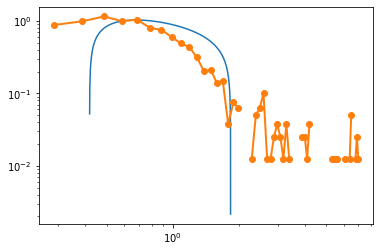

In [13]:
import powerlaw

fit1=powerlaw.Fit(eigs,xmin=1e-1,xmax=2*np.max(eigs),discrete=False,density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0

T=len(U)
print(T)
gamma=(1.0*nspec)/T
print(gamma)
x=np.arange(1e-4, 1e2, 0.001)
data=marchpast(x,gamma)
data[data == 0] = 'nan'

plt.plot(x, data)

probc,binsc=np.histogram(eigs,np.arange(np.min(eigs),np.max(eigs),0.1),density=True)
probc[probc == 0] = 'nan'
binsc = (binsc[1:]+binsc[:-1])/2.0
probc[probc == 0] = 'nan'
plt.plot(binsc,probc,marker='o',lw=2)
plt.xscale('log')
plt.yscale('log')

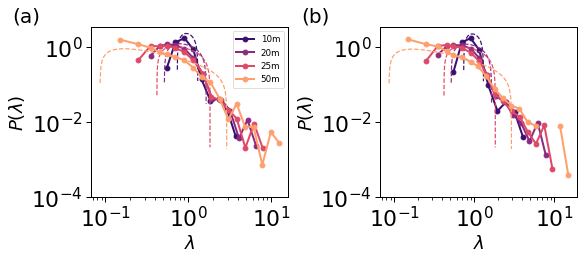

In [30]:
from farrow_and_ball import *
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import numpy as np
import seaborn as sns
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
import matplotlib as mpl
import matplotlib.colors
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot
import matplotlib.ticker
import networkx as nx
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import powerlaw

ax_dict = plt.figure(constrained_layout=True,figsize=(8,3.5)).subplot_mosaic(
    """
     AB
    """
)

nspec=100
lv=[10,20,25,50]
pal = sns.color_palette('magma', n_colors=len(lv), desat=1.0)

for l in lv:
    Eigs=pd.read_csv('PearsonCorr_l'+str(l)+'_Eigs_average',delimiter=' ',header=None)[0]
    fit1=powerlaw.Fit(Eigs,xmin=1e-1,xmax=2*np.max(Eigs),discrete=False,
                      density=True,fit_method='KS')
    binsc, probc=fit1.pdf(linear_bins=False,density=True)
    probc[probc == 0] = 'nan'
    binsc = (binsc[1:]+binsc[:-1])/2.0
    c1=pal.pop(0)
    ax_dict['A'].plot(binsc,probc,marker='o',lw=2,label=str(l)+'m',color=c1)
    T=(1000/l)*(500/l)
    gamma=(1.0*nspec)/T
    x=np.arange(1e-4, 1e2, 0.001)
    data=marchpast(x,gamma)
    data[data == 0] = 'nan'
    ax_dict['A'].plot(x, data,ls='--',color=c1)

ax_dict['A'].legend()
ax_dict['A'].set_xscale('log')
ax_dict['A'].set_yscale('log')
ax_dict['A'].set_xticks([1e-1,1e0,1e1])
ax_dict['A'].set_yticks([1e-4,1e-2,1e0])
ax_dict['A'].set_ylabel(r'$P(\lambda)$')
ax_dict['A'].set_xlabel(r'$\lambda$')


pal = sns.color_palette('magma', n_colors=len(lv), desat=1.0)
for l in lv:
    Eigs=pd.read_csv('SpearmanCorr_l'+str(l)+'_Eigs_average',delimiter=' ',header=None)[0]
    fit1=powerlaw.Fit(Eigs,xmin=1e-1,xmax=2*np.max(Eigs),discrete=False,density=True,fit_method='KS')
    binsc, probc=fit1.pdf(linear_bins=False,density=True)
    probc[probc == 0] = 'nan'
    binsc = (binsc[1:]+binsc[:-1])/2.0
    c1=pal.pop(0)
    ax_dict['B'].plot(binsc,probc,marker='o',lw=2,color=c1)
    T=(1000/l)*(500/l)
    gamma=(1.0*nspec)/T
    x=np.arange(1e-4, 1e2, 0.001)
    data=marchpast(x,gamma)
    data[data == 0] = 'nan'
    ax_dict['B'].plot(x, data,ls='--',color=c1)
ax_dict['B'].set_xscale('log')
ax_dict['B'].set_yscale('log')
ax_dict['B'].set_xticks([1e-1,1e0,1e1])
ax_dict['B'].set_yticks([1e-4,1e-2,1e0])
ax_dict['B'].set_ylabel(r'$P(\lambda)$')
ax_dict['B'].set_xlabel(r'$\lambda$')


ax_dict['A'].text(-0.4, 1.03, '(a)', transform=ax_dict['A'].transAxes, 
            size=20)
ax_dict['B'].text(-0.4, 1.03, '(b)', transform=ax_dict['B'].transAxes, 
            size=20)

#plt.savefig('Correlations.pdf')
plt.show()

Census 8


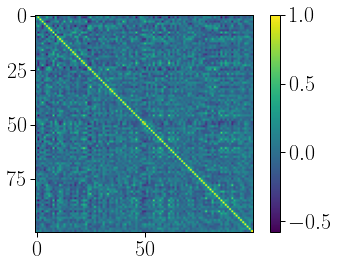

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
import scipy.stats


nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i in range(nspec):
    nm=Recount[i][1]
    N=Recount[i][0]
    filt = BCI[BCI[3] == nm.strip()]
    hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
    #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
    U=np.array((list(chain.from_iterable(hist))))
    #np.random.shuffle(U)
    UVec[i]=U
#Corr1=scipy.stats.spearmanr(UVec,axis=1)
Corr=np.corrcoef(UVec)
#w=np.abs(np.linalg.eigvalsh(Corr1.correlation))
#eigs=np.concatenate((eigs, w), axis=None)
plt.imshow(Corr)
plt.colorbar()

In [9]:
N=100
T=(Lx/Lb)*(Ly/Lb)
C1=MarchenkoPastur(Corr,N,T,remove_largest=False)


0.08578643762690485 2.914213562373095


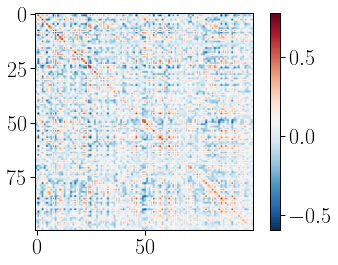

In [10]:
plt.imshow(C1,cmap='RdBu_r')
plt.colorbar()

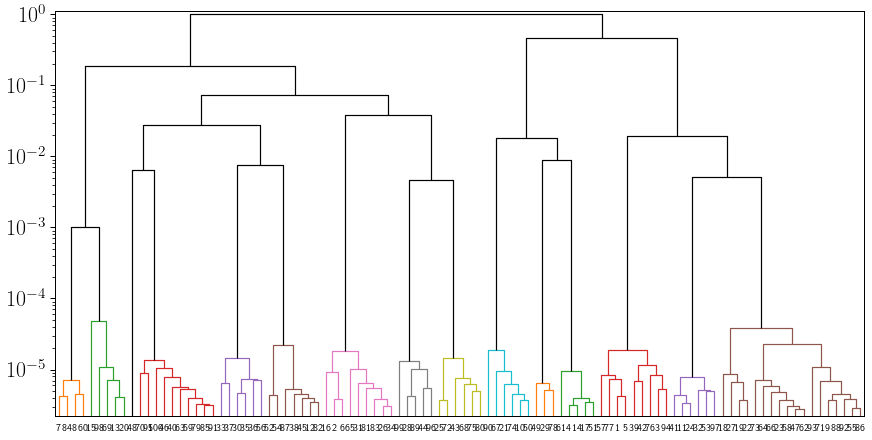

In [13]:
from scipy.cluster.hierarchy import cophenet
import networkx as nx
import numpy as np
from scipy.linalg import expm, sinm, cosm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import networkx as nx


fig=plt.figure(constrained_layout=True,figsize=(12,6))

pearson1=np.copy(C1)
pearson1[pearson1<0]=0
G = nx.from_numpy_array(np.abs(pearson1))
G.remove_edges_from(nx.selfloop_edges(G))
#nx.draw(G,node_size=15,width=0.05,edge_color='gray')

#G = nx.karate_club_graph()
L=nx.laplacian_matrix(G)
#L=nx.laplacian_matrix(G)
L1=L.todense()
w=1/nx.laplacian_spectrum(G)

#Put a small value of tau here, we want macro-clusters
#Control that clusters are stable along different values of tau
#Th controls the threshold in the dendrogram, linkage can be changed from 'average' to 'complete'
#Control also that this does not change the results
tau=1e-3

num=expm((-tau*L1))
den=np.trace(num)
rho=num/den

Trho=np.copy(1.0/rho)#1/adj2
Trho=np.tril(Trho) + np.triu(Trho.T, 1)
#Trho = np.maximum(Trho, Trho.transpose() )
np.fill_diagonal(Trho, 0)

dists = squareform(Trho)
linkage_matrix = linkage(dists, "ward")
labelList = [i+1 for i in range(0, len(G.nodes()))]
tmax=linkage_matrix[::, 2][-1]#+0.01*linkage_matrix[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "ward")
Th=1e-4
dendrogram(linkage_matrix,labels=labelList,leaf_rotation=0,color_threshold=Th,above_threshold_color='k',leaf_font_size=10)
CM=fcluster(linkage_matrix, t=Th, criterion='distance')

tmin=linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax=linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]

plt.ylim(tmin,tmax)
plt.yscale('log')
plt.show()

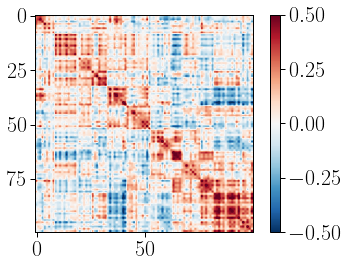

In [14]:
import matplotlib.colors as colors

idx   = np.argsort(CM)
N=len(idx)
comm = np.sort(CM)
A2 = [[C1[i][j] for j in idx] for i in idx]

# define your scale, with white at zero
vmin = -0.5
vmax = 0.5#np.max(A2)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.imshow(A2,cmap='RdBu_r',rasterized='True',interpolation=None,norm=norm)
plt.colorbar()
#plt.imshow()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Census 1
0.08578643762690485 2.914213562373095



 12%|█████▋                                       | 1/8 [00:05<00:35,  5.05s/it]

Census 2
0.08578643762690485 2.914213562373095



 25%|███████████▎                                 | 2/8 [00:10<00:31,  5.32s/it]

Census 3
0.08578643762690485 2.914213562373095



 38%|████████████████▉                            | 3/8 [00:16<00:27,  5.55s/it]

Census 4
0.08578643762690485 2.914213562373095



 50%|██████████████████████▌                      | 4/8 [00:22<00:22,  5.60s/it]

Census 5
0.08578643762690485 2.914213562373095



 62%|████████████████████████████▏                | 5/8 [00:27<00:16,  5.53s/it]

Census 6
0.08578643762690485 2.914213562373095



 75%|█████████████████████████████████▊           | 6/8 [00:32<00:10,  5.49s/it]

Census 7
0.08578643762690485 2.914213562373095



 88%|███████████████████████████████████████▍     | 7/8 [00:38<00:05,  5.42s/it]

Census 8
0.08578643762690485 2.914213562373095



100%|█████████████████████████████████████████████| 8/8 [00:43<00:00,  5.44s/it]


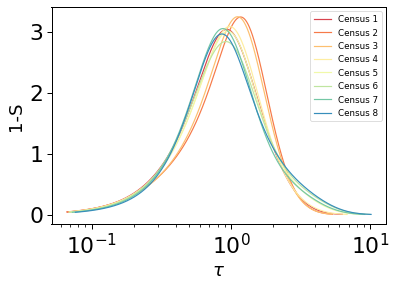

In [35]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
import scipy.stats


nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]
pal = sns.color_palette('Spectral', n_colors=8, desat=1.0)


for j in tqdm(range(1,9)):
    print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        #np.random.shuffle(U)
        UVec[i]=U
    Corr=np.corrcoef(UVec)
    N=nspec
    T=(Lx/Lb)*(Ly/Lb)
    C1=MarchenkoPastur(Corr,N,T,remove_largest=False)
    pearson1=np.copy(C1)
    pearson1[pearson1<0]=0
    G = nx.from_numpy_array(np.abs(pearson1))
    G.remove_edges_from(nx.selfloop_edges(G))
    [S1,dS1,VarL1,t1]=entropy(G,1000)
    #[S1,dS1,VarL1,C1,CVar1,t1]=entropyF(G,300)
    #plt.plot(t1,S1,label='Census '+str(j),color=c1)
    t11 = (t1[1:]+t1[:-1])/2.0
    c1=pal.pop(0)
    plt.plot(t11,dS1,ls='-',color=c1,label='Census '+str(j))
    #plt.plot(t1,1/CVar1,ls='--',color=c1,label='Census '+str(j))

plt.legend()
plt.ylabel('1-S')
plt.xlabel(r'$\tau$')
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [112]:
print(len(np.unique(CM)))
index=np.where(CM==1)[0]
print(index)
Nombres=np.array(Recount)[:,1][0:100]

print(Nombres[index])

14
[28 48 60 77]
['psycho' 'randar' 'gustsu' 'tri2pa']


Census 8
0.08578643762690485 2.914213562373095


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Census 1
0.08578643762690485 2.914213562373095



 12%|█████▋                                       | 1/8 [00:05<00:35,  5.11s/it]

Census 2
0.08578643762690485 2.914213562373095



 25%|███████████▎                                 | 2/8 [00:10<00:31,  5.26s/it]

Census 3
0.08578643762690485 2.914213562373095



 38%|████████████████▉                            | 3/8 [00:16<00:27,  5.43s/it]

Census 4
0.08578643762690485 2.914213562373095



 50%|██████████████████████▌                      | 4/8 [00:21<00:21,  5.45s/it]

Census 5
0.08578643762690485 2.914213562373095



 62%|████████████████████████████▏                | 5/8 [00:26<00:15,  5.31s/it]

Census 6
0.08578643762690485 2.914213562373095



 75%|█████████████████████████████████▊           | 6/8 [00:31<00:10,  5.25s/it]

Census 7
0.08578643762690485 2.914213562373095



 88%|███████████████████████████████████████▍     | 7/8 [00:37<00:05,  5.25s/it]

Census 8
0.08578643762690485 2.914213562373095



100%|█████████████████████████████████████████████| 8/8 [00:42<00:00,  5.28s/it]


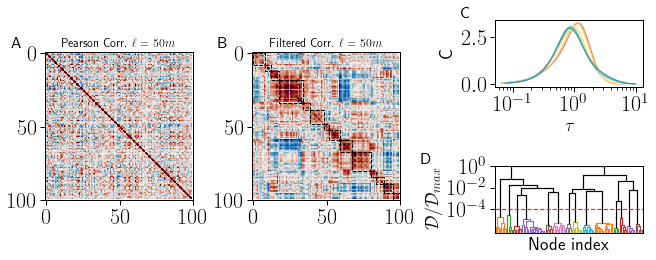

In [423]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import matplotlib.patches as patches


ax_dict = plt.figure(constrained_layout=True,figsize=(9,3.5)).subplot_mosaic(
    """
    AABBCC
    AABBDD
    """
)
#fig = plt.figure(constrained_layout=True,figsize=(10, 10))
#ax_dict = fig.subplot_mosaic(layout)
    
#Take CMAP
cmap1 = cmocean.cm.delta   #Green/blue
cmap2 = cmocean.cm.balance #Red/blue

#Compute Corr Matrix
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i in range(nspec):
    nm=Recount[i][1]
    N=Recount[i][0]
    filt = BCI[BCI[3] == nm.strip()]
    hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
    #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
    U=np.array((list(chain.from_iterable(hist))))
    #np.random.shuffle(U)
    UVec[i]=U
#Corr1=scipy.stats.spearmanr(UVec,axis=1)
Corr=np.corrcoef(UVec)
N=100
T=(Lx/Lb)*(Ly/Lb)
C1=MarchenkoPastur(Corr,N,T,remove_largest=False)

# define your scale, with white at zero
vmin = -0.5
vmax = 0.5#np.max(A2)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

pearson1=np.copy(C1)
pearson1[pearson1<0]=0
G = nx.from_numpy_array(np.abs(pearson1))
G.remove_edges_from(nx.selfloop_edges(G))

L=nx.laplacian_matrix(G)
L1=L.todense()
w=1/nx.laplacian_spectrum(G)

#Put a small value of tau here, we want macro-clusters
#Control that clusters are stable along different values of tau
#Th controls the threshold in the dendrogram, linkage can be changed from 'average' to 'complete'
#Control also that this does not change the results
tau=1e-3

num=expm((-tau*L1))
den=np.trace(num)
rho=num/den

Trho=np.copy(1.0/rho)#1/adj2
Trho=np.tril(Trho) + np.triu(Trho.T, 1)
np.fill_diagonal(Trho, 0)

dists = squareform(Trho)
linkage_matrix = linkage(dists, "complete")
labelList = [i+1 for i in range(0, len(G.nodes()))]
tmax=linkage_matrix[::, 2][-1]#+0.01*linkage_matrix[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "complete")
Th=1e-4
dendrogram(linkage_matrix,labels=labelList,ax=ax_dict['D'],leaf_rotation=0,orientation='top',
           color_threshold=Th,above_threshold_color='k',leaf_font_size=10)
CM=fcluster(linkage_matrix, t=Th, criterion='distance')

idx   = np.argsort(CM)
N=len(idx)
comm = np.sort(CM)
A2 = [[C1[i][j] for j in idx] for i in idx]

im=ax_dict['A'].imshow(Corr,cmap=cmap2,rasterized='True',interpolation=None,norm=norm)
ax_dict['A'].set_xticks([0,50,100])
ax_dict['A'].set_yticks([0,50,100])
ax_dict['A'].set_title(r'Pearson Corr. $\ell=50m$',fontsize=12)
ax_dict['A'].text(-0.23, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')

im2=ax_dict['B'].imshow(A2,cmap=cmap2,rasterized='True',interpolation=None,norm=norm)
ax_dict['B'].set_xticks([0,50,100])
ax_dict['B'].set_yticks([0,50,100])
ax_dict['B'].set_title(r'Filtered Corr. $\ell=50m$',fontsize=12)
ax_dict['B'].text(-0.23, 1.03, 'B', transform=ax_dict['B'].transAxes, 
            size=16, weight='bold')

bounds = _grid_communities(CM)
bounds[0] += 0.2
bounds[-1] -= 0.2
for n, edge in enumerate(np.diff(bounds)):
        ax_dict['B'].add_patch(patches.Rectangle((bounds[n], bounds[n]),
                                       edge, edge, fill=False, linewidth=1,ls='--',
                                       edgecolor='black'))


#Specific Heat Calculation
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]
pal = sns.color_palette('Spectral', n_colors=8, desat=1.0)


for j in tqdm(range(1,9)):
    print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        #np.random.shuffle(U)
        UVec[i]=U
    Corr=np.corrcoef(UVec)
    N=nspec
    T=(Lx/Lb)*(Ly/Lb)
    C1=MarchenkoPastur(Corr,N,T,remove_largest=False)
    pearson1=np.copy(C1)
    pearson1[pearson1<0]=0
    G = nx.from_numpy_array(np.abs(pearson1))
    G.remove_edges_from(nx.selfloop_edges(G))
    [S1,dS1,VarL1,t1]=entropy(G,1000)
    #[S1,dS1,VarL1,C1,CVar1,t1]=entropyF(G,300)
    #plt.plot(t1,S1,label='Census '+str(j),color=c1)
    t11 = (t1[1:]+t1[:-1])/2.0
    c1=pal.pop(0)
    ax_dict['C'].plot(t11,dS1,ls='-',color=c1,label='Census '+str(j))
    #plt.plot(t1,1/CVar1,ls='--',color=c1,label='Census '+str(j))

#ax_dict['C'].legend()
ax_dict['C'].set_ylabel('C')
ax_dict['C'].set_xlabel(r'$\tau$')
ax_dict['C'].set_xscale('log')
#plt.yscale('log')
ax_dict['C'].text(-0.23, 1.03, 'C', transform=ax_dict['C'].transAxes, 
            size=16, weight='bold')


ax_dict['D'].set_xscale('linear')
tmin=linkage_matrix[::, 2][0]-0.2*linkage_matrix[::, 2][0]
tmax=linkage_matrix[::, 2][-1]+0.1*linkage_matrix[::, 2][-1]
ax_dict['D'].set_ylim(tmin,tmax)
ax_dict['D'].axhline(y = Th, color = '#ED2939', linestyle = '--')
ax_dict['D'].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$')
ax_dict['D'].set_xlabel('Node index')
ax_dict['D'].set_yscale('log')
ax_dict['D'].set_yticks([1e-4,1e-2,1e0])
ax_dict['D'].set_xticks([])
ax_dict['D'].text(-0.5, 1.03, 'D', transform=ax_dict['D'].transAxes, 
            size=16, weight='bold')

#plt.colorbar(im, ax=ax_dict['A'])
#plt.colorbar(im2, ax=ax_dict['B'])


plt.savefig('BCI-Matrices.pdf')
plt.show()

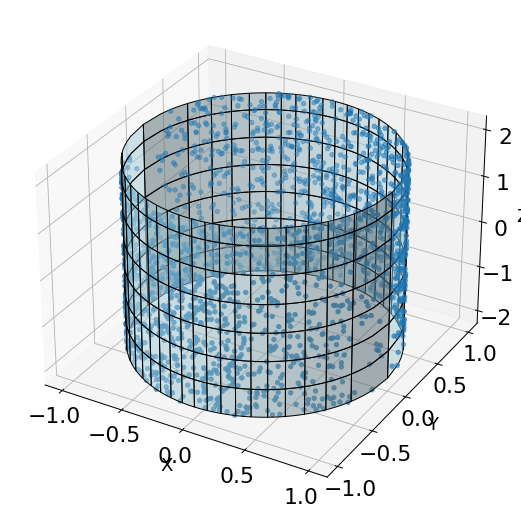

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter graph
N = 2000
X = np.random.uniform(-1, 1, N)
Y = np.sqrt(1-X**2)*random.choice([-1,1],N)
Z = np.random.uniform(-2, 2, N)
ax.scatter(X, Y, Z)

# Cylinder
x=np.linspace(-1, 1, 100)
z=np.linspace(-2, 2, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(1-Xc**2)

# Draw parameters
rstride = 15
cstride = 5
ax.plot_surface(Xc, Yc, Zc, alpha=0.5, linewidth=1,edgecolors='black', rstride=rstride, cstride=cstride,color='lightblue')
ax.plot_surface(Xc, -Yc, Zc, alpha=0.5, linewidth=1,edgecolors='black',rstride=rstride, cstride=cstride,color='lightblue')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

Text(-0.05, 1.03, 'D')

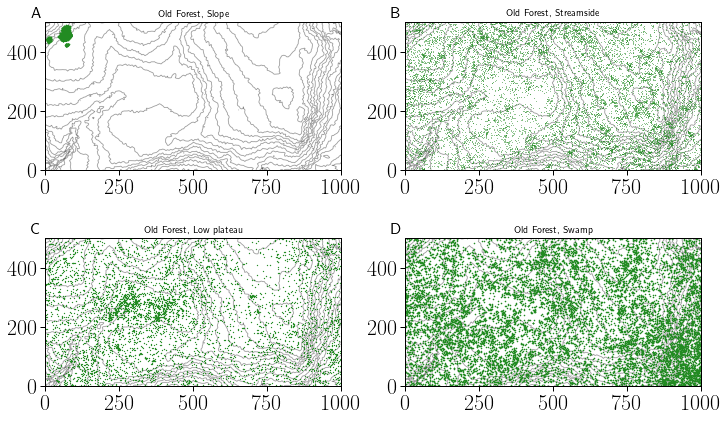

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmocean

BCI = pd.read_csv("bcitree8.dat",delimiter=' ',header=None) 
Names = pd.read_csv("Names_BCI.csv",delimiter=',',header=None) 

nms=Names[0]
Fnms=Names[2]
Nmbr=Names[1]

ax_dict = plt.figure(constrained_layout=True,figsize=(10,6)).subplot_mosaic(
    """
    AABB
    CCDD
    """
)
im = plt.imread('Level.png')
#Plot A
implot = ax_dict['A'].imshow(im[::-1],origin='lower',alpha=0.8)
index=np.where(CM==4)[0]
pal = sns.color_palette('cmo.algae', n_colors=len(index), desat=1.0)

Nombres=np.array(Recount)[:,1][0:100]
for nm in Nombres[index]:
    filt = BCI[BCI[3] == nm.strip()]
    i=int(np.where(nms==nm)[0])
    if (i>2):
        ax_dict['A'].scatter(filt[0],filt[1],s=10/(len(index)*np.log10(len(filt))),
                         rasterized=True,marker='.',label=Fnms[i],color='forestgreen')

ax_dict['A'].set_xlim(0,1000)
ax_dict['A'].set_ylim(0,500)
ax_dict['A'].set_title('Old Forest, Slope')
ax_dict['A'].text(-0.05, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')


#Figure B
implot = ax_dict['B'].imshow(im[::-1],origin='lower',alpha=0.8)
index=np.where(CM==13)[0]
pal = sns.color_palette('cmo.algae', n_colors=len(index), desat=1.0)
pal.reverse()
Nombres=np.array(Recount)[:,1][0:100]
for nm in Nombres[index]:
    filt = BCI[BCI[3] == nm.strip()]
    i=int(np.where(nms==nm)[0])
    if (i>2):
        ax_dict['B'].scatter(filt[0],filt[1],s=5/(len(index)*np.log10(len(filt))),
                         rasterized=True,marker='.',label=Fnms[i],color='forestgreen')

ax_dict['B'].set_xlim(0,1000)
ax_dict['B'].set_ylim(0,500)
ax_dict['B'].set_title('Old Forest, Streamside')
ax_dict['B'].text(-0.05, 1.03, 'B', transform=ax_dict['B'].transAxes, 
            size=16, weight='bold')

#Figure C
implot = ax_dict['C'].imshow(im[::-1],origin='lower',alpha=0.8)
index=np.where(CM==9)[0]
pal = sns.color_palette('cmo.algae', n_colors=len(index), desat=1.0)
pal.reverse()
Nombres=np.array(Recount)[:,1][0:100]
for nm in Nombres[index]:
    filt = BCI[BCI[3] == nm.strip()]
    i=int(np.where(nms==nm)[0])
    if (i>2):
        ax_dict['C'].scatter(filt[0],filt[1],s=20/(len(index)*np.log10(len(filt))),
                         rasterized=True,marker='.',label=Fnms[i],color='forestgreen')

ax_dict['C'].set_xlim(0,1000)
ax_dict['C'].set_ylim(0,500)
ax_dict['C'].set_title('Old Forest, Low plateau')
ax_dict['C'].text(-0.05, 1.03, 'C', transform=ax_dict['C'].transAxes, 
            size=16, weight='bold')

#Figure D
implot = ax_dict['D'].imshow(im[::-1],origin='lower',alpha=0.8)
index=np.where(CM==1)[0]
pal = sns.color_palette('cmo.algae', n_colors=len(index), desat=1.0)
pal.reverse()
Nombres=np.array(Recount)[:,1][0:100]
for nm in Nombres[index]:
    filt = BCI[BCI[3] == nm.strip()]
    i=int(np.where(nms==nm)[0])
    if (i>2):
        ax_dict['D'].scatter(filt[0],filt[1],s=35/(len(index)*np.log10(len(filt))),
                         rasterized=True,marker='.',label=Fnms[i],color='forestgreen')

ax_dict['D'].set_xlim(0,1000)
ax_dict['D'].set_ylim(0,500)
ax_dict['D'].set_title('Old Forest, Swamp')
ax_dict['D'].text(-0.05, 1.03, 'D', transform=ax_dict['D'].transAxes, 
            size=16, weight='bold')
#plt.savefig('Communities.pdf')

In [32]:
sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

[(0.6922722029988467, 0.09227220299884642, 0.16770472895040373),
 (0.8392156862745097, 0.37647058823529417, 0.3019607843137255),
 (0.954555940023068, 0.641753171856978, 0.5057285659361782),
 (0.9921568627450981, 0.8588235294117645, 0.780392156862745),
 (0.9657054978854286, 0.9672433679354094, 0.9680891964628989),
 (0.8196078431372551, 0.8980392156862745, 0.9411764705882353),
 (0.5664744329104194, 0.7687043444828915, 0.8685121107266436),
 (0.26274509803921564, 0.576470588235294, 0.7647058823529411),
 (0.1272587466359093, 0.39584775086505203, 0.6687427912341407)]

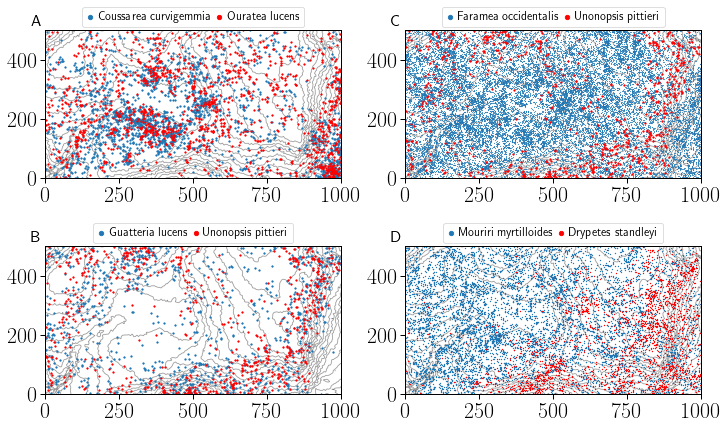

In [390]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

BCI = pd.read_csv("bcitree8.dat",delimiter=' ',header=None) 
Names = pd.read_csv("Names_BCI.csv",delimiter=',',header=None) 

nms=Names[0]
Fnms=Names[2]
Nmbr=Names[1]

ax_dict = plt.figure(constrained_layout=True,figsize=(10,6)).subplot_mosaic(
    """
    AACC
    BBDD
    """
)
im = plt.imread('Level.png')
#Plot A
implot = ax_dict['A'].imshow(im[::-1],origin='lower',alpha=0.8)
nm=str('cou2cu')
filt = BCI[BCI[3] == nm.strip()]
i=int(np.where(nms==nm)[0])
ax_dict['A'].scatter(filt[0],filt[1],s=2,rasterized=True,label=Fnms[i])
nm=str('ouralu')
i=int(np.where(nms==nm)[0])
filt = BCI[BCI[3] == nm.strip()]
ax_dict['A'].scatter(filt[0],filt[1],s=2,color='red',rasterized=True,label=Fnms[i])
lgd=ax_dict['A'].legend(ncol=2,loc='upper center',markerscale=10,columnspacing=0.4,handlelength=0.5,handletextpad=0.4,bbox_to_anchor=(0.5,1.2),fontsize=12)
for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])
ax_dict['A'].set_xlim(0,1000)
ax_dict['A'].set_ylim(0,500)

ax_dict['A'].text(-0.05, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')

#Plot B
implot = ax_dict['B'].imshow(im[::-1],origin='lower',alpha=0.8)
nm=str('guatdu')
filt = BCI[BCI[3] == nm.strip()]
i=int(np.where(nms==nm)[0])
ax_dict['B'].scatter(filt[0],filt[1],s=2,rasterized=True,label=Fnms[i])
nm=str('unonpi')
i=int(np.where(nms==nm)[0])
filt = BCI[BCI[3] == nm.strip()]
ax_dict['B'].scatter(filt[0],filt[1],s=2,color='red',rasterized=True,label=Fnms[i])
lgd=ax_dict['B'].legend(ncol=2,loc='upper center',markerscale=10,columnspacing=0.4,handlelength=0.5,handletextpad=0.4,bbox_to_anchor=(0.5,1.2),fontsize=12)
for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])
ax_dict['B'].set_xlim(0,1000)
ax_dict['B'].set_ylim(0,500)

ax_dict['B'].text(-0.05, 1.03, 'B', transform=ax_dict['B'].transAxes, 
            size=16, weight='bold')

#Plot C
implot = ax_dict['C'].imshow(im[::-1],origin='lower',alpha=0.8)
nm=str('faraoc')
filt = BCI[BCI[3] == nm.strip()]
i=int(np.where(nms==nm)[0])
ax_dict['C'].scatter(filt[0],filt[1],s=0.1,rasterized=True,label=Fnms[i])
nm=str('unonpi')
i=int(np.where(nms==nm)[0])
filt = BCI[BCI[3] == nm.strip()]
ax_dict['C'].scatter(filt[0],filt[1],s=2,color='red',rasterized=True,label=Fnms[i])
lgd=ax_dict['C'].legend(ncol=2,loc='upper center',markerscale=10,columnspacing=0.4,handlelength=0.5,handletextpad=0.4,bbox_to_anchor=(0.5,1.2),fontsize=12)
for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])
ax_dict['C'].set_xlim(0,1000)
ax_dict['C'].set_ylim(0,500)

ax_dict['C'].text(-0.05, 1.03, 'C', transform=ax_dict['C'].transAxes, 
            size=16, weight='bold')

#Plot B
implot = ax_dict['D'].imshow(im[::-1],origin='lower',alpha=0.8)
nm=str('mourmy')
filt = BCI[BCI[3] == nm.strip()]
i=int(np.where(nms==nm)[0])
ax_dict['D'].scatter(filt[0],filt[1],s=0.3,rasterized=True,label=Fnms[i])
nm=str('drypst')
i=int(np.where(nms==nm)[0])
filt = BCI[BCI[3] == nm.strip()]
ax_dict['D'].scatter(filt[0],filt[1],s=0.3,color='red',rasterized=True,label=Fnms[i])
lgd=ax_dict['D'].legend(ncol=2,loc='upper center',markerscale=10,columnspacing=0.4,handlelength=0.5,handletextpad=0.4,bbox_to_anchor=(0.5,1.2),fontsize=12)
for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])
ax_dict['D'].set_xlim(0,1000)
ax_dict['D'].set_ylim(0,500)

ax_dict['D'].text(-0.05, 1.03, 'D', transform=ax_dict['D'].transAxes, 
            size=16, weight='bold')

plt.savefig('Species.pdf')
#plt.tight_layout()
plt.show()

In [355]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors

#Compute Corr Matrix
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i in range(nspec):
    nm=Recount[i][1]
    N=Recount[i][0]
    filt = BCI[BCI[3] == nm.strip()]
    hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
    #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
    U=np.array((list(chain.from_iterable(hist))))
    #np.random.shuffle(U)
    UVec[i]=U
#Corr1=scipy.stats.spearmanr(UVec,axis=1)
Corr=np.corrcoef(UVec)
N=100
T=(Lx/Lb)*(Ly/Lb)
C1=MarchenkoPastur(Corr,N,T,remove_largest=False)


Census 8
0.08578643762690485 2.914213562373095


In [373]:
np.fill_diagonal(C1,0)
np.fill_diagonal(Corr,0)
C2=np.triu(C1)
#C2=np.triu(Corr)
#C2=np.triu(np.abs(np.abs(Corr)-np.abs(C1)))
Nombres=np.array(Recount)[:,1][0:100]

topN=10
small_elems = sorted(C2.ravel(),reverse=False)[:topN]
for i in range(topN):
    i1=np.where(C2==small_elems[i])[0][0]
    j1=np.where(C2==small_elems[i])[1][0]
    #if (np.abs(C1[i1,j1])>np.abs(Corr[i1,j1])):
    print(Corr[i1,j1],C1[i1,j1],-Corr[i1,j1]+C1[i1,j1],i1,j1,Nombres[i1],Nombres[j1],i)



-0.5794519098456095 -0.5973593292419633 -0.017907419396353874 1 61 faraoc unonpi 0
-0.5311962730722464 -0.5502280745700052 -0.01903180149775885 1 46 faraoc guatdu 1
-0.5103443461009424 -0.5441526815624752 -0.033808335461532835 1 85 faraoc chr1ec 2
-0.47175899143150524 -0.5323332920100334 -0.060574300578528195 1 8 faraoc hirttr 3
-0.4822314306476253 -0.5192876954319469 -0.03705626478432156 1 54 faraoc poular 4
-0.5175782655408306 -0.5187888229203245 -0.0012105573794938262 1 57 faraoc protco 5
-0.4052486857098547 -0.5008611635644221 -0.09561247785456745 25 61 cou2cu unonpi 6
-0.41045268445662425 -0.48714178779740264 -0.07668910334077839 25 57 cou2cu protco 7
-0.492563216968243 -0.4867954508185873 0.005767766149655684 5 18 mourmy drypst 8
-0.37927214710933554 -0.4849443196629631 -0.10567217255362754 50 90 talipr ingath 9


Text(-0.05, 1.03, 'A')

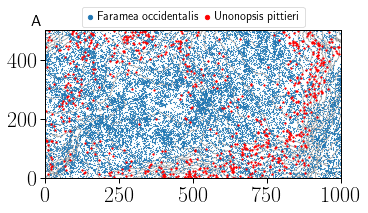

In [387]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

i=0
i1=np.where(C2==small_elems[i])[0][0]
j1=np.where(C2==small_elems[i])[1][0]


BCI = pd.read_csv("bcitree8.dat",delimiter=' ',header=None) 
Names = pd.read_csv("Names_BCI.csv",delimiter=',',header=None) 

nms=Names[0]
Fnms=Names[2]
Nmbr=Names[1]

ax_dict = plt.figure(constrained_layout=True,figsize=(5,3)).subplot_mosaic(
    """
    AA
    """
)
im = plt.imread('Level.png')
#Plot A
implot = ax_dict['A'].imshow(im[::-1],origin='lower',alpha=0.8)
nm=str(Nombres[i1])
filt = BCI[BCI[3] == nm.strip()]
i=int(np.where(nms==nm)[0])
ax_dict['A'].scatter(filt[0],filt[1],s=0.1,rasterized=True,label=Fnms[i])
nm=str(Nombres[j1])
i=int(np.where(nms==nm)[0])
filt = BCI[BCI[3] == nm.strip()]
ax_dict['A'].scatter(filt[0],filt[1],s=2,color='red',rasterized=True,label=Fnms[i])
lgd=ax_dict['A'].legend(ncol=2,loc='upper center',markerscale=10,columnspacing=0.4,handlelength=0.5,handletextpad=0.4,bbox_to_anchor=(0.5,1.2),fontsize=12)
for legend_handle in lgd.legendHandles:
    legend_handle.set_sizes([20])
ax_dict['A'].set_xlim(0,1000)
ax_dict['A'].set_ylim(0,500)

ax_dict['A'].text(-0.05, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')

In [408]:
def _grid_communities(communities):
    """
    Generates boundaries of `communities`

    Parameters
    ----------
    communities : array_like
        Community assignment vector

    Returns
    -------
    bounds : list
        Boundaries of communities
    """

    communities = np.asarray(communities)
    if 0 in communities:
        communities = communities + 1

    comm = communities[np.argsort(communities)]
    bounds = []
    for i in np.unique(comm):
        ind = np.where(comm == i)
        if len(ind) > 0:
            bounds.append(np.min(ind))

    bounds.append(len(communities))

    return bounds

Census 8
0.08578643762690485 2.914213562373095


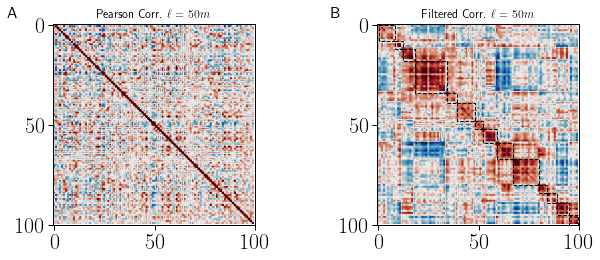

In [421]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


ax_dict = plt.figure(constrained_layout=True,figsize=(9,3.5)).subplot_mosaic(
    """
    AABB
    AABB
    """
)
#fig = plt.figure(constrained_layout=True,figsize=(10, 10))
#ax_dict = fig.subplot_mosaic(layout)
    
#Take CMAP
cmap1 = cmocean.cm.delta   #Green/blue
cmap2 = cmocean.cm.balance #Red/blue

#Compute Corr Matrix
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i in range(nspec):
    nm=Recount[i][1]
    N=Recount[i][0]
    filt = BCI[BCI[3] == nm.strip()]
    hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
    #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
    U=np.array((list(chain.from_iterable(hist))))
    #np.random.shuffle(U)
    UVec[i]=U
#Corr1=scipy.stats.spearmanr(UVec,axis=1)
Corr=np.corrcoef(UVec)
N=100
T=(Lx/Lb)*(Ly/Lb)
C1=MarchenkoPastur(Corr,N,T,remove_largest=False)

# define your scale, with white at zero
vmin = -0.5
vmax = 0.5#np.max(A2)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

pearson1=np.copy(C1)
pearson1[pearson1<0]=0
G = nx.from_numpy_array(np.abs(pearson1))
G.remove_edges_from(nx.selfloop_edges(G))

L=nx.laplacian_matrix(G)
L1=L.todense()
w=1/nx.laplacian_spectrum(G)

#Put a small value of tau here, we want macro-clusters
#Control that clusters are stable along different values of tau
#Th controls the threshold in the dendrogram, linkage can be changed from 'average' to 'complete'
#Control also that this does not change the results
tau=1e-3

num=expm((-tau*L1))
den=np.trace(num)
rho=num/den

Trho=np.copy(1.0/rho)#1/adj2
Trho=np.tril(Trho) + np.triu(Trho.T, 1)
np.fill_diagonal(Trho, 0)

dists = squareform(Trho)
linkage_matrix = linkage(dists, "complete")
labelList = [i+1 for i in range(0, len(G.nodes()))]
tmax=linkage_matrix[::, 2][-1]#+0.01*linkage_matrix[::, 2][-1]
linkage_matrix = linkage(dists/tmax, "complete")
CM=fcluster(linkage_matrix, t=Th, criterion='distance')

idx   = np.argsort(CM)
N=len(idx)
comm = np.sort(CM)
A2 = [[C1[i][j] for j in idx] for i in idx]

im=ax_dict['A'].imshow(Corr,cmap=cmap2,rasterized='True',interpolation=None,norm=norm)
ax_dict['A'].set_xticks([0,50,100])
ax_dict['A'].set_yticks([0,50,100])
ax_dict['A'].set_title(r'Pearson Corr. $\ell=50m$',fontsize=12)
ax_dict['A'].text(-0.23, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')

im2=ax_dict['B'].imshow(A2,cmap=cmap2,rasterized='True',interpolation=None,norm=norm)
ax_dict['B'].set_xticks([0,50,100])
ax_dict['B'].set_yticks([0,50,100])
ax_dict['B'].set_title(r'Filtered Corr. $\ell=50m$',fontsize=12)
ax_dict['B'].text(-0.23, 1.03, 'B', transform=ax_dict['B'].transAxes, 
            size=16, weight='bold')



Census 8


100%|███████████████████████████████████| 1855/1855 [00:00<00:00, 449346.46it/s]


TypeError: Axes3D.view_init() got an unexpected keyword argument 'roll'

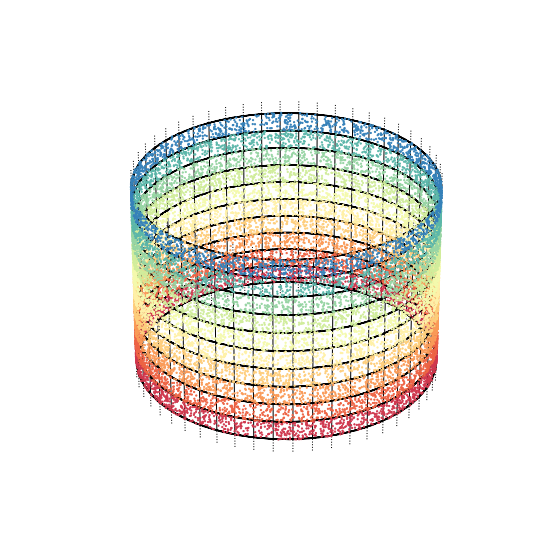

In [75]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#Compute Corr Matrix
nspec=10
Lx=1000
Ly=500
Lb=100
l=Lb
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
pal = sns.color_palette('Spectral', n_colors=nspec, desat=1.0)

#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i1 in range(20,20+nspec):
    nm=Recount[i1][1]
    N=Recount[i1][0]
    filt = BCI[BCI[3] == nm.strip()]
    maxx=int(1000/l)
    maxy=int(500/l)
    nb=maxx*maxy
    a=np.zeros((len(filt),2))
    gx=np.array(filt[0])
    gy=np.array(filt[1])
    #gx = 1000*np.random.rand(len(gx))
    #gy = 500*np.random.rand(len(gx))
    for i in tqdm(range(len(filt))):
        bx=int(gx[i]/(1.0*l))+1
        by=int(gy[i]/(1.0*l))+1
        if(gx[i]==Lx):
            bx=maxx-1
        if(gy[i]==Ly):
            by=maxy-1
        if(gx[i]==0):
            bx=1
        if(gy[i]==0):
            by=1
        if (((gx[i]/(1.0*l))>(1.0*maxx))&((gy[i]/(1.0*l))>(1.0*maxy))):
            print('Error assigning points')
        a[i]=[bx,by]

    cont=0
    a1=np.zeros((len(filt),2))
    count=np.zeros((nb))
    for i in range(maxx):
        for j in range(maxy):
            a1[cont]=[i+1,j+1]
            count[cont]=cont
            cont=cont+1

    gx1=np.zeros(len(gx))
    gy1=np.zeros(len(gx))
    for i in range(len(filt)):
        indx=np.where(np.sum(np.abs((a[i]-a1)),axis=1)==0)[0][0]
        gx1[i]=gx[i]+1.0*l*np.where(np.sum(np.abs((a[i]-a1)),axis=1)==0)[0][0]
        gy1[i]=gy[i]-1.0*(a1[indx,1]-1)*(l)+(i1-20)*l
    #gx1=2*np.pi*gx1/(np.max(gx1))
    # Scatter graph
    ax.scatter(np.cos(gx1), np.sin(gx1), gy1,s=2,alpha=1.0,color=pal.pop(0),rasterized=True)
    
# Prepare arrays x, y, z
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z2 = 0.0
r = 1.0
x2 = r * np.sin(theta)
y2 = r * np.cos(theta)
#ax.plot(x2, y2, z2, label='parametric curve',color='black')
for i in range(nspec+1):
    ax.plot(x2, y2, z2+i*l, label='parametric curve',color='black')
z3 = np.linspace(0,1,100)
#ax.scatter(1, 0, z3, label='parametric curve',color='red')
Nbox=int((Lx/l)*(Ly/l))
for i in range(Nbox):
    phi=i*2*np.pi/Nbox
    ax.plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[0,nspec*l],
            color = 'black',lw=1)
    ax.plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[-70,0],
            color = 'black',lw=1,ls=':')
    ax.plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[nspec*l,nspec*l+70],
            color = 'black',lw=1,ls=':')
    
ax.set_axis_off()    
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=45, roll=-5)
plt.savefig('Cylinder.png')

Census 8


100%|█████████████████████████████████████████| 299/299 [00:06<00:00, 43.31it/s]


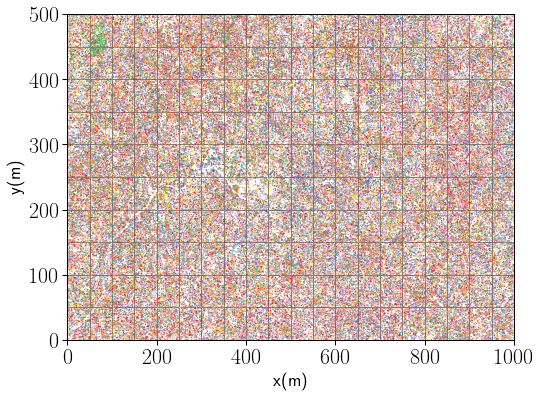

In [50]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))

#Compute Corr Matrix
Lx=1000
Ly=500
Lb=50
l=Lb
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 

#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
nspec=len(np.unique(BCI[3]))
pal = sns.color_palette('Set1', n_colors=nspec, desat=1.0)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i1 in tqdm(range(0,nspec)):
    nm=Recount[i1][1]
    N=Recount[i1][0]
    filt = BCI[BCI[3] == nm.strip()]
    maxx=int(1000/l)
    maxy=int(500/l)
    nb=maxx*maxy
    a=np.zeros((len(filt),2))
    gx=np.array(filt[0])
    gy=np.array(filt[1])
    plt.scatter(gx,gy,color=pal.pop(0),s=0.001*(np.abs(np.array(filt[2]))),rasterized=True)
    
for i in range(int(Ly/l)):
    plt.plot([0,Lx],[(i+1)*l,(i+1)*l],color = 'gray',lw=1,zorder=-5)
for i in range(int(Lx/l)):
    plt.plot([(i+1)*l,(i+1)*l],[0,Ly],color = 'gray',lw=1,zorder=-5)

    
    
plt.xlim(0,1000)
plt.ylim(0,500)
plt.ylabel('y(m)')
plt.xlabel('x(m)')
plt.savefig('BCI-Scatter.png',dpi=300)
plt.show()

/tmp/ipykernel_18884/873747471.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_dict['B'] =  plt.subplot(2,2,3, projection='3d')


Census 8


100%|███████████████████████████████████| 1855/1855 [00:00<00:00, 489643.42it/s]


Census 8


100%|█████████████████████████████████████████| 299/299 [00:03<00:00, 79.91it/s]


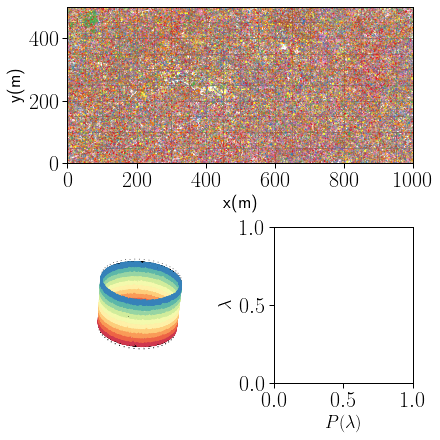

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

ax_dict = plt.figure(constrained_layout=True,figsize=(6,6)).subplot_mosaic(
    """
    CC
    BA
    """
)

#EIGENVALUE DISTRIBUTION
ax_dict['A'].set_ylabel(r'$\lambda$')
ax_dict['A'].set_xlabel(r'$P(\lambda)$')


#CYLINDER
ax_dict['B'] =  plt.subplot(2,2,3, projection='3d')
#Compute Corr Matrix
nspec=10
Lx=1000
Ly=500
Lb=100
l=Lb
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
pal = sns.color_palette('Spectral', n_colors=nspec, desat=1.0)

#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i1 in range(20,20+nspec):
    nm=Recount[i1][1]
    N=Recount[i1][0]
    filt = BCI[BCI[3] == nm.strip()]
    maxx=int(1000/l)
    maxy=int(500/l)
    nb=maxx*maxy
    a=np.zeros((len(filt),2))
    gx=np.array(filt[0])
    gy=np.array(filt[1])
    #gx = 1000*np.random.rand(len(gx))
    #gy = 500*np.random.rand(len(gx))
    for i in tqdm(range(len(filt))):
        bx=int(gx[i]/(1.0*l))+1
        by=int(gy[i]/(1.0*l))+1
        if(gx[i]==Lx):
            bx=maxx-1
        if(gy[i]==Ly):
            by=maxy-1
        if(gx[i]==0):
            bx=1
        if(gy[i]==0):
            by=1
        if (((gx[i]/(1.0*l))>(1.0*maxx))&((gy[i]/(1.0*l))>(1.0*maxy))):
            print('Error assigning points')
        a[i]=[bx,by]

    cont=0
    a1=np.zeros((len(filt),2))
    count=np.zeros((nb))
    for i in range(maxx):
        for j in range(maxy):
            a1[cont]=[i+1,j+1]
            count[cont]=cont
            cont=cont+1

    gx1=np.zeros(len(gx))
    gy1=np.zeros(len(gx))
    for i in range(len(filt)):
        indx=np.where(np.sum(np.abs((a[i]-a1)),axis=1)==0)[0][0]
        gx1[i]=gx[i]+1.0*l*np.where(np.sum(np.abs((a[i]-a1)),axis=1)==0)[0][0]
        gy1[i]=gy[i]-1.0*(a1[indx,1]-1)*(l)+(i1-20)*l
    #gx1=2*np.pi*gx1/(np.max(gx1))
    # Scatter graph
    ax_dict['B'].scatter(np.cos(gx1), np.sin(gx1), gy1,s=2,alpha=1.0,color=pal.pop(0),rasterized=True)
    
# Prepare arrays x, y, z
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z2 = 0.0
r = 1.0
x2 = r * np.sin(theta)
y2 = r * np.cos(theta)
#ax.plot(x2, y2, z2, label='parametric curve',color='black')
for i in range(nspec+1):
    ax_dict['B'].plot(x2, y2, z2+i*l, label='parametric curve',color='black')
z3 = np.linspace(0,1,100)
#ax.scatter(1, 0, z3, label='parametric curve',color='red')
Nbox=int((Lx/l)*(Ly/l))
for i in range(Nbox):
    phi=i*2*np.pi/Nbox
    ax_dict['B'].plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[0,nspec*l],
            color = 'black',lw=1)
    ax_dict['B'].plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[-70,0],
            color = 'black',lw=1,ls=':')
    ax_dict['B'].plot([r*np.cos(phi),r*np.cos(phi)],[r*np.sin(phi),r*np.sin(phi)],[nspec*l,nspec*l+70],
            color = 'black',lw=1,ls=':')
    
ax_dict['B'].set_axis_off()    
ax_dict['B'].set_xticks([])
ax_dict['B'].set_yticks([])
ax_dict['B'].set_zticks([])
ax_dict['B'].view_init(elev=30, azim=45, roll=-5)

#SCATTER PLOT
#Compute Corr Matrix
Lx=1000
Ly=500
Lb=50
l=Lb
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 

#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
nspec=len(np.unique(BCI[3]))
pal = sns.color_palette('Set1', n_colors=nspec, desat=1.0)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i1 in tqdm(range(0,nspec)):
    nm=Recount[i1][1]
    N=Recount[i1][0]
    filt = BCI[BCI[3] == nm.strip()]
    maxx=int(1000/l)
    maxy=int(500/l)
    nb=maxx*maxy
    a=np.zeros((len(filt),2))
    gx=np.array(filt[0])
    gy=np.array(filt[1])
    ax_dict['C'].scatter(gx,gy,color=pal.pop(0),s=0.001*(np.abs(np.array(filt[2]))),rasterized=True)
    
for i in range(int(Ly/l)):
    ax_dict['C'].plot([0,Lx],[(i+1)*l,(i+1)*l],color = 'gray',lw=1,zorder=-5)
for i in range(int(Lx/l)):
    ax_dict['C'].plot([(i+1)*l,(i+1)*l],[0,Ly],color = 'gray',lw=1,zorder=-5)

    
    
ax_dict['C'].set_xlim(0,1000)
ax_dict['C'].set_ylim(0,500)
ax_dict['C'].set_ylabel('y(m)')
ax_dict['C'].set_xlabel('x(m)')

plt.savefig('Sketch.svg')
plt.show()

In [36]:
from itertools import chain

#Compute Corr Matrix
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]
eigs1=[]
#Select Census
for j in range(8,9):
    print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        filt[0] = 1000*np.random.rand(len(filt[0]))
        filt[1] = 500*np.random.rand(len(filt[1]))
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        UVec[i]=U
    Corr=np.corrcoef(UVec)
    w1=np.abs(np.linalg.eigvalsh(Corr))
    eigs1=np.concatenate((eigs1, w1), axis=None)
    for nreps in tqdm(range(1000)):
        UVec1=np.copy(UVec)
        #for k in range(10):
        posit=random.sample(range(1, len(U)-1), nspec)
        for i in range(nspec):
            #posit=1+random.randrange(len(U)-1)
            #U=np.array(UVec[i])
            #np.random.shuffle(U)
            #UVec1[i]=U
            UVec1[i]=np.roll(UVec[i],posit[i])

        Corr=np.corrcoef(UVec1)
        w=np.abs(np.linalg.eigvalsh(Corr))
        eigs=np.concatenate((eigs, w), axis=None)


Census 8


/tmp/ipykernel_9897/1383436614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt[0] = 1000*np.random.rand(len(filt[0]))
/tmp/ipykernel_9897/1383436614.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt[1] = 500*np.random.rand(len(filt[1]))
100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 308.15it/s]


200
0.5


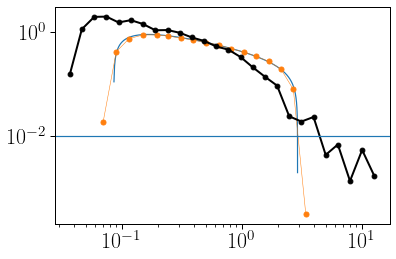

In [79]:
import powerlaw
from scipy.ndimage import gaussian_filter
#eigs=np.copy(w)
#probc,binsc=np.histogram(eigs,np.arange(8e-2,2*np.max(eigs),0.01),density=True)
fit1=powerlaw.Fit(eigs,xmin=1e-2,xmax=2*np.max(eigs),discrete=False,density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0

np.save('Census_'+str(j)+'_l_'+str(Lb)+'_Eigs_Random.npy', [binsc,probc])
T=len(U)
print(T)
gamma=(1.0*nspec)/T
print(gamma)
x=np.arange(1e-4, 1e2, 0.001)
data=marchpast(x,gamma)
data[data == 0] = 'nan'

plt.plot(x, data)

#probc[probc == 0] = 'nan'
#binsc = (binsc[1:]+binsc[:-1])/2.0
probc[probc == 0] = 'nan'
result = gaussian_filter(probc, sigma=0.1)
plt.plot(binsc,result,lw=0.5,marker='o',markersize=5)




#eigs=np.copy(w1)
fit1=powerlaw.Fit(eigs1,xmin=1e-3,xmax=2*np.max(eigs1),discrete=False,
                  density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
#probc,binsc=np.histogram(eigs1,np.arange(5e-2,2*np.max(eigs),0.1),density=True)
#probc,binsc=np.histogram(eigs1,np.arange(1e-2,2*np.max(eigs1),0.05),density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0
probc[probc == 0] = 'nan'
plt.plot(binsc,probc,marker='o',lw=2,color='black')

plt.axhline(y=2/T)

plt.xscale('log')
plt.yscale('log')

In [54]:
print(np.min(eigs[eigs>1e-3]))
print(np.min(eigs1[eigs1>1e-3]))

print(np.max(eigs[eigs>1e-3]))
print(np.max(eigs1[eigs1>1e-3]))

0.2316556378898319
0.3334206029322423
3.9764209794814063
5.453131970830768


200
0.5
[0.16265059 5.14984412] [0.01 0.01]


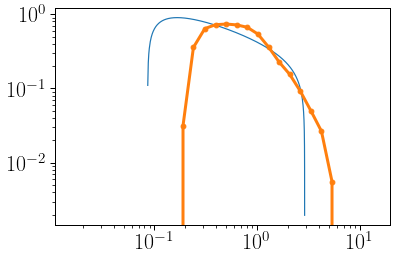

In [113]:
import powerlaw
#eigs=np.copy(w)
#probc,binsc=np.histogram(eigs,np.arange(0.5*np.min(eigs),2*np.max(eigs),0.05),density=True)
fit1=powerlaw.Fit(eigs,xmin=1e-2,xmax=2*np.max(eigs),discrete=False,density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0

T=len(U)
print(T)
gamma=(1.0*nspec)/T
print(gamma)
x=np.arange(1e-4, 1e2, 0.001)
data=marchpast(x,gamma)
data[data == 0] = 'nan'

plt.plot(x, data)

#probc[probc == 0] = 'nan'
#binsc = (binsc[1:]+binsc[:-1])/2.0
probc[probc <= 5e-4] = 0
plt.plot(binsc,probc,marker='o',lw=3)

import matplotlib.pyplot as plt
import numpy as np


def find_intersections(x, y, C):
    # Contains numpy indexing tricks that can be hard to reproduce
    # in the case where both functions are non-constants
    ii, = np.nonzero((y[1:]-C)*(y[:-1]-C) < 0.)  # intersection indices
    x_intersections = x[ii] + (C - y[ii])/(y[1+ii] - y[ii])*(x[1+ii] - x[ii])
    y_intersections = C * np.ones(len(ii))
    return x_intersections, y_intersections


xint, yint = find_intersections(binsc, probc, 1e-2)
print(xint,yint)

plt.xscale('log')
plt.yscale('log')

In [55]:
for j in range(8,9):
    print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        UVec[i]=U
    Corr=np.corrcoef(UVec)


w, v = np.linalg.eigh(Corr)  # Spectral decomposition of C
    
w_min = 0.23
w_max = 3.97

selected = (w < w_min) | (w > w_max)


w_signal = w[selected]
v_signal = v[:, selected]

C_new = v_signal.dot(np.diag(w_signal)).dot(v_signal.T)

Census 8


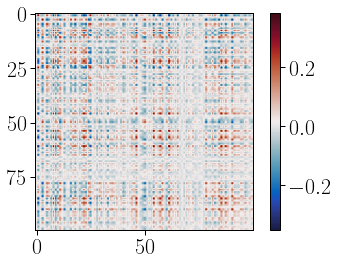

In [56]:
import cmocean

cmap2 = cmocean.cm.balance #Red/blue

plt.imshow(C_new,cmap=cmap2)
plt.colorbar()

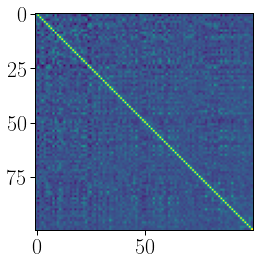

In [35]:
plt.imshow(Corr)

(0.001, 4)

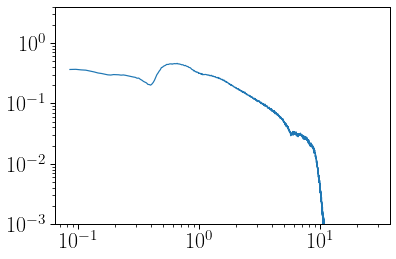

In [155]:
p=np.load('Census_8_l_100_Eigs_Random.npy')
plt.plot(p[0],p[1])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-3,4)

In [22]:
print(len(UVec[0]))

5000


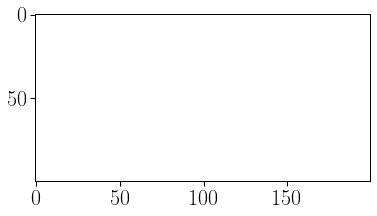

In [15]:
plt.imshow(UVec)

Census 8


100%|█████████████████████████████████████████████| 8/8 [00:39<00:00,  5.00s/it]


200
0.5


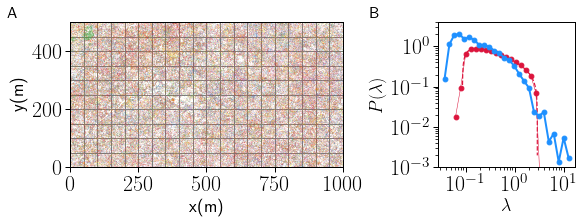

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmocean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
from sklearn.datasets import make_blobs
import gc
import sys
from numpy import random
import powerlaw
from scipy.spatial.distance import pdist,squareform
from itertools import chain
from tqdm import tqdm
from scipy.cluster.hierarchy import fcluster
import scipy.stats
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.markers import MarkerStyle
from itertools import chain
import powerlaw
from scipy.ndimage import gaussian_filter

ax_dict = plt.figure(constrained_layout=True,figsize=(8,3)).subplot_mosaic(
    """
    CCA
    """
)

#SCATTER PLOT
#Compute Corr Matrix
Lx=1000
Ly=500
Lb=50
l=Lb
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]

#Select Census
j=8
print('Census '+str(j))
BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 

#Select the more abundant species
#nm=str('hybapr')
Count=np.zeros(len(Names),dtype=int)
nspec=len(np.unique(BCI[3]))
pal = sns.color_palette('Set1', n_colors=nspec, desat=1.0)
cont=0
for nm in Names[0]:
    filt = BCI[BCI[3] == nm.strip()]
    Count[cont]=len(filt[3])
    cont=cont+1

Recount=list(zip(Count,Names[0]))
Recount.sort(reverse=True)
UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
for i1 in tqdm(range(0,nspec)):
    nm=Recount[i1][1]
    N=Recount[i1][0]
    filt = BCI[BCI[3] == nm.strip()]
    maxx=int(1000/l)
    maxy=int(500/l)
    nb=maxx*maxy
    a=np.zeros((len(filt),2))
    gx=np.array(filt[0])
    gy=np.array(filt[1])
    #*np.log10(1+np.abs(np.array(filt[2])))
    ax_dict['C'].scatter(gx,gy,color=pal.pop(0),marker=MarkerStyle("o", fillstyle="full"),
                         edgecolors='none',s=0.125,
                         rasterized=True)
    
for i in range(int(Ly/l)):
    ax_dict['C'].plot([0,Lx],[(i+1)*l,(i+1)*l],color = 'gray',lw=1,zorder=-5)
for i in range(int(Lx/l)):
    ax_dict['C'].plot([(i+1)*l,(i+1)*l],[0,Ly],color = 'gray',lw=1,zorder=-5)

    
    
ax_dict['C'].set_xlim(0,1000)
ax_dict['C'].set_ylim(0,500)
ax_dict['C'].set_ylabel('y(m)')
ax_dict['C'].set_xlabel('x(m)')

#Compute Corr Matrix
nspec=100
Lx=1000
Ly=500
Lb=50
Names = pd.read_csv("NamesBCI",delimiter=' ',header=None)
eigs=[]
eigs1=[]
#Select Census
for j in tqdm(range(1,9)):
    #print('Census '+str(j))
    BCI = pd.read_csv('bcitree'+str(j)+'.dat',delimiter=' ',header=None) 
    #Select the more abundant species
    #nm=str('hybapr')
    Count=np.zeros(len(Names),dtype=int)
    cont=0
    for nm in Names[0]:
        filt = BCI[BCI[3] == nm.strip()]
        Count[cont]=len(filt[3])
        cont=cont+1

    Recount=list(zip(Count,Names[0]))
    Recount.sort(reverse=True)
    UVec=np.zeros((nspec,int(Lx/Lb*Ly/Lb)))
    for i in range(nspec):
        nm=Recount[i][1]
        N=Recount[i][0]
        filt = BCI[BCI[3] == nm.strip()]
        hist, xedges, yedges = np.histogram2d(filt[1], filt[0], bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
        #UVec= np.vstack([UVec, np.array(list(chain.from_iterable(hist)))])
        U=np.array((list(chain.from_iterable(hist))))
        UVec[i]=U
    Corr=np.corrcoef(UVec)
    w1=np.abs(np.linalg.eigvalsh(Corr))
    eigs1=np.concatenate((eigs1, w1), axis=None)
    for nreps in (range(10)):
        UVec1=np.copy(UVec)
        #for k in range(10):
        #posit=random.sample(range(1, len(U)-1), nspec)
        for i in range(nspec):
            #posit=1+random.randrange(len(U)-1)
            U=np.array(UVec[i])
            np.random.shuffle(U)
            #UVec1[i]=U
            UVec1[i]=U

        Corr=np.corrcoef(UVec1)
        w=np.abs(np.linalg.eigvalsh(Corr))
        eigs=np.concatenate((eigs, w), axis=None)


#EIGENVALUE DISTRIBUTION
#eigs=np.copy(w)
#probc,binsc=np.histogram(eigs,np.arange(1e-3,2*np.max(eigs),0.01),density=True)
fit1=powerlaw.Fit(eigs,xmin=1e-3,xmax=2*np.max(eigs),discrete=False,density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0

T=len(U)
print(T)
gamma=(1.0*nspec)/T
print(gamma)
x=np.arange(1e-4, 1e2, 0.001)
data=marchpast(x,gamma)
data[data == 0] = 'nan'

ax_dict['A'].plot(x, data,color='crimson',ls='--')

probc[probc == 0] = 'nan'
result = gaussian_filter(probc, sigma=0.1)
ax_dict['A'].plot(binsc,result,marker='o',lw=0.5,zorder=-5,color='crimson')




#eigs=np.copy(w1)
fit1=powerlaw.Fit(eigs1,xmin=1e-3,xmax=2*np.max(eigs1),discrete=False,
                  density=True,fit_method='KS')
binsc, probc=fit1.pdf(linear_bins=False,density=True)
#probc,binsc=np.histogram(eigs1,np.arange(5e-2,2*np.max(eigs),0.1),density=True)
#probc,binsc=np.histogram(eigs1,np.arange(1e-2,2*np.max(eigs1),0.05),density=True)
binsc = (binsc[1:]+binsc[:-1])/2.0
probc[probc == 0] = 'nan'
ax_dict['A'].plot(binsc,probc,marker='o',lw=2,color='dodgerblue')


ax_dict['A'].set_xscale('log')
ax_dict['A'].set_yscale('log')
ax_dict['A'].set_ylim(1e-3,4)


ax_dict['A'].set_xlabel(r'$\lambda$')
ax_dict['A'].set_ylabel(r'$P(\lambda)$')

ax_dict['A'].text(-0.5, 1.03, 'B', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')
ax_dict['C'].text(-0.23, 1.03, 'A', transform=ax_dict['C'].transAxes, 
            size=16, weight='bold')


plt.savefig('Sketch.pdf',dpi=600)
plt.show()

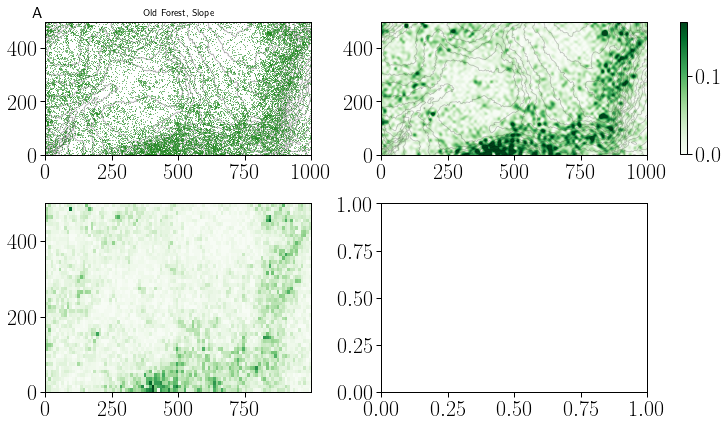

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmocean

BCI = pd.read_csv("bcitree8.dat",delimiter=' ',header=None) 
Names = pd.read_csv("Names_BCI.csv",delimiter=',',header=None) 

nms=Names[0]
Fnms=Names[2]
Nmbr=Names[1]

ax_dict = plt.figure(constrained_layout=True,figsize=(10,6)).subplot_mosaic(
    """
    AABB
    CCDD
    """
)
im = plt.imread('Level.png')
#Plot A
implot = ax_dict['A'].imshow(im[::-1],origin='lower',alpha=0.8)
index=np.where(CM==15)[0]
pal = sns.color_palette('cmo.algae', n_colors=len(index), desat=1.0)

Nombres=np.array(Recount)[:,1][0:100]
gx=[]
gy=[]
for nm in Nombres[index]:
    filt = BCI[BCI[3] == nm.strip()]
    gx = np.append(gx,filt[0])
    gy = np.append(gy,filt[1])
    i=int(np.where(nms==nm)[0])
    if (i>2):
        ax_dict['A'].scatter(filt[0],filt[1],s=10/(len(index)*np.log10(len(filt))),
                         rasterized=True,marker='.',label=Fnms[i],color='forestgreen')
hist, xedges, yedges = np.histogram2d(filt[1], filt[0],
                                      bins=[int(Ly/Lb),int(Lx/Lb)], range=[[0, Ly], [0, Lx]])
ax_dict['A'].set_xlim(0,1000)
ax_dict['A'].set_ylim(0,500)
ax_dict['A'].set_title('Old Forest, Slope')
ax_dict['A'].text(-0.05, 1.03, 'A', transform=ax_dict['A'].transAxes, 
            size=16, weight='bold')

l=10
implot = ax_dict['B'].imshow(im[::-1],origin='lower',alpha=0.5,zorder=10)
h, x, y, p = ax_dict['C'].hist2d(gx, gy, bins=(int(Lx/l), int(Ly/l)),cmap='Greens')
#Plot A
im=ax_dict['B'].imshow(np.transpose(h/(l*l)), origin = "lower", 
                    interpolation = 'lanczos',
                       cmap='Greens',extent=[0,1000,0,500],
                      vmin=0,vmax=np.mean(h/(l*l))+3*np.std(h/(l*l)))
ax_dict['B'].set_xlim(0,1000)
ax_dict['B'].set_ylim(0,500)
plt.colorbar(im,shrink=0.7)

plt.show()

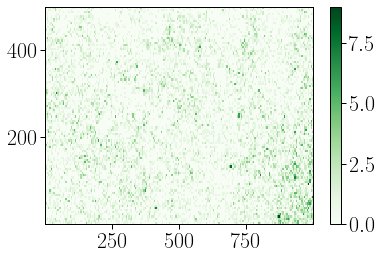

In [48]:
l=5
plt.hist2d(gx, gy, bins=(int(Lx/l), int(Ly/l)), cmap='Greens')
plt.colorbar()
plt.show()

In [189]:
print(np.mean(h/(l*l))+np.std(h/(l*l)))
print(np.std(h/(l*l)))

0.017687062651400107
0.011133062651400108
